# SICSS Norrköping 2023: Text Analysis (SOLUTIONS)

_Hendrik Erz, Institute for Analytical Sociology | <hendrik.erz@liu.se> | Twitter: @sahiralsaid_

Welcome to the practical part of the Text Analaysis day! In this notebook, you will try out some of the methods covered in the morning lecture. In particular, the methods covered will be:

* tf-idf scores
* topic modeling
* Word2Vec

Below, you will see several exercises that cover most of the steps from an unprocessed text corpus to a final trained model, and, lastly the analysis step.

You will work on these examples in smaller groups with guidance from me.

## Preliminaries: Loading the Corpus

Your task in this exercise is to write a function that will return parts of the corpus in a way that the models we are using works with. Here, we will be working with a corpus of the **[States of the Union (SOTU)](https://en.wikipedia.org/wiki/State_of_the_Union) of the U.S. presidents**.

***

The first step is always to load the corpus. We will use a **generator** for this, since a generator helps us keep the memory footprint small and therefore to keep the model training times low.

Normally, you would have the corpus downloaded to your computer, but since we're on a Google Colab, we'll have to retrieve it from the web first. Since I provide the corpus, below you can find a ready-made function that will automatically return the corpus in the following format:

```python
corpus = [
    ('This is a speech from a republican', 'R'),
    ('This is a speech from a democrat', 'D'),
    # ...
]
```

As you can see, you will get from this generator function a list of **tuples**. The first element is always a speech, the second element is a letter indicating the president's party. The party codes are as follows:

* R: Republican
* D: Democrat
* W: Whig
* F: Federalist
* DR: Democratic-Republican
* na: No party
* NU: National Union

***

**Whenever you need the speeches, just call `speeches()` in your code**

In [99]:
def speeches ():
  """A generator that yields (speech, party) tuples"""
  # NOTE: Ensure that the file is in the same directory as this notebook.
  with open("sotu.csv", "r", encoding="utf-8") as fp:
    next(fp) # Skip the header
    for line in fp:
      # title, author, date, text = line.strip().split('\t')
      # yield (title, author, date, text)
      speech, party = line.strip().split('\t')
      yield (speech, party)

In [34]:
# Make sure we have all 251 speeches in our generator
sum([1 for x in speeches()])

251

## Preliminaries: Installing the necessary packages

This workbook relies on a set of packages. Depending on what package manager you use, there are various ways to install them (e.g., with Conda, pip, or virtualenv).

Make sure to install them according to how you have set up Python. If you use plain `pip`, here is how you can install them:

```bash
python -m pip install pandas
python -m pip install numpy
python -m pip install gensim
python -m pip install sklearn
python -m pip install nltk
python -m pip install matplotlib
```

## Getting to Know the Corpus

Before we dive into the corpus, we should make sure we have some bearings in the corpus. For this, a very simple method is to simply start counting words. This is not necessarily the most informative method, but it will give us some data that we can use to make some sense of the corpus.

Getting to some word counts involves a few steps:

1. First, we need a **tokenizer** that can split up a speech into tokens.
2. After we have a method of splitting a document into its constitutent words, we can use this information to build a vocabulary.
3. We can count words to ensure our corpus looks as it should.

### Exercise 1: Write a text tokenizer

Below, write a function that takes a single speech and returns a list of tokens. You should remove digits, punctuation marks, and other symbols that do not comprise regular, English words. Also, ensure that capitalization of letters does not matter by transforming the speech into lower case first.

> TIP: The NLTK package offers a lot of useful functions for working with natural language. It includes functions to remove stopwords and to tokenize a text. Also, the String class of Python provides additional easy functions you can use.

In [38]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Loads a common english stopword list
stops = stopwords.words('english')

def tokenize_speech(speech):
  return [t for t in word_tokenize(speech.lower()) if t.isalpha() and t not in stops]

In [61]:
# Run this cell to see how the preprocessor processes the first speech.
first_speech = next(speeches())[0]
tokenize_speech(first_speech)[0:10] # Look at the first ten words

['good',
 'afternoon',
 'beginning',
 'new',
 'year',
 'reflect',
 'state',
 'american',
 'union',
 'seek']

### Exercise 2: Build a Vocabulary

We will need a vocabulary for many of the following steps, so it makes sense to write a dedicated function for it. The easiest form of a vocabulary is a dictionary that maps words to indices:

```python
vocab = {
    'word': 0,
    'word2': 1,
    # ...
}
```

Since we also need to figure out words by their indices after running some of our methods, we should create a so-called `i2w`-dictionary. The `i2w` ("index to word") performs the reverse lookup and maps indices to words:

```python
iw2 = {
    0: 'word',
    1: 'word2',
    # ...
}
```

We can then use these dictionaries to retrieve indices or words, depending on what we need:

```python
vocab['president']
# > May yield '24'

word = i2w[24]
# > May yield 'president'
```

Below, write a function that returns both a vocab and an i2w.

In [40]:
def build_vocab ():
  # First generate the word -> index mapping
  vocab = {}
  for speech, _ in speeches():
    for token in tokenize_speech(speech):
      if not token in vocab:
        # This basically adds unseen words to the end of the vocabulary
        vocab[token] = len(vocab)

  # Now reverse it (important later), i.e. index -> word mapping.
  # i2w = index2word
  i2w = {}
  for token in vocab:
    i2w[vocab[token]] = token

  return vocab, i2w

In [46]:
# Run this cell to create the vocabulary
vocab, i2w = build_vocab()

In [62]:
# Let us have a first look at the first ten words in our vocabulary. Note how
# the first ten words in our vocab equal the first words of the first speech.
list(vocab.keys())[0:10]

['good',
 'afternoon',
 'beginning',
 'new',
 'year',
 'reflect',
 'state',
 'american',
 'union',
 'seek']

### Exercise 3: Count words

The final introductory exercise involves counting words. Python luckily has a useful function for us: `Counter`.

In [47]:
# Below, write a function that can count the words and returns a list of words
# and their frequencies.
from collections import Counter

def count_words ():
  word_counter = Counter()
  for speech, _ in speeches():
    word_counter.update(tokenize_speech(speech))
  return word_counter.most_common()

In [100]:
# Let us now look at the ten most common, and then ten least common words:

words = count_words()

print("Most common words:")
print(words[0:10])

print("")
print("Least common words:")
print(words[-10:])

Most common words:
[('government', 7644), ('states', 6990), ('congress', 5942), ('united', 5202), ('year', 4841), ('people', 4511), ('would', 4343), ('upon', 4253), ('country', 3733), ('must', 3713)]

Least common words:
[('arabic', 1), ('transforms', 1), ('shuffling', 1), ('screenings', 1), ('wellness', 1), ('computerizing', 1), ('athletics', 1), ('players', 1), ('crescent', 1), ('reentry', 1)]


### Verify Zipf's Law

One great way of ensuring that your corpus does not include oddities and spurious data, a very simple verification involves checking for Zipf's law: The fact that a few words are very common, and many words are relatively uncommon. A histogram of words should resemple a logarithmic function.

Below, plot the frequencies ordered by rank.

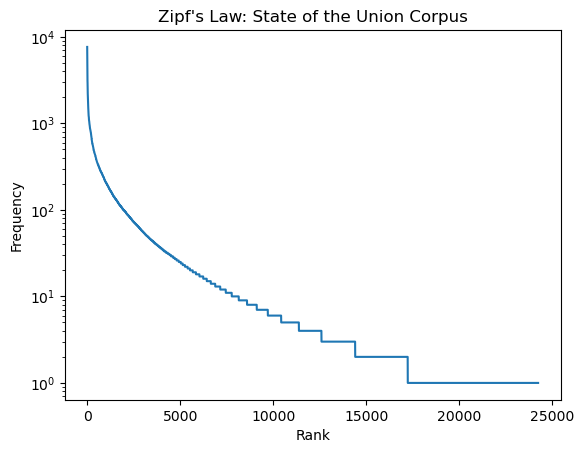

In [101]:
import matplotlib.pyplot as plt

# Extract only the actual numbers, and sort them by size descending.
word_counts = sorted(list(map(lambda x: x[1], words)), reverse=True)

plt.plot(range(len(word_counts)), word_counts)
plt.yscale("log") # Set the Y-axis to a logarithmic scale.
plt.ylabel("Frequency")
plt.xlabel("Rank")
plt.title("Zipf's Law: State of the Union Corpus")
plt.show()

## Computing tf-idf scores

The most simple way to begin an analysis is by calculating tf-idf scores. You can do this "manually", but for practical usage, there are some libraries that already do that for you.

Calculating tf-idf scores consists of three steps:

1. Calculate the term frequencies of words within each document
2. Calculate the inverse document frequency for each word
3. For each word in each document, calculate tf-idf by multiplying the document-specific frequency with the word's IDF-score

Remember, tf-idf is defined as:

$$
{\displaystyle \text{tf-idf} (t, d, D) = \mathrm{tf} (t,d) \times \mathrm{idf}}(t, D)
$$

where

$$
{\displaystyle \mathrm {tf} (t,d)={\frac {f_{t,d}}{\sum _{t'\in d}{f_{t',d}}}}}
$$

with $t$ = the term in question, $t'$ = all other terms, and $f_t$ = the (document)relative frequency of the term. And:

$$
 \mathrm{idf}(t, D) =  \log \frac{N}{1 + D}
$$

with $N$ = total number of documents in the corpus and $D$ = number of documents that contain term $t$.

### Exercise 4: Calculate tf-idf scores

Below, write a function that calculates tf-idf scores for our corpus and then outputs the most relevant word for each speech.

> The library `scikit-learn` has a useful function for that called `TfidfVectorizer`. You will need to pass it the vocabulary and the speeches.

In [78]:
from sklearn.feature_extraction.text import TfidfVectorizer

def calculate_tf_idf ():
  vocab, _ = build_vocab()
  tfidf = TfidfVectorizer(vocabulary=vocab, tokenizer=tokenize_speech)
  text = [speech[0] for speech in speeches()]
  # NOTE: fit_transform returns a DTM of size (n_documents x n_words) where each
  # cell contains the corresponding tf-idf score.
  document_term_matrix = tfidf.fit_transform(text)

  # Transform the matrix into a list of dictionaries with the corresponding
  # tf-idf scores for easier inspection
  tf_idf = list()
  n_documents, n_words = document_term_matrix.shape

  for doc in range(n_documents):
    scores = dict()
    for word_idx in range(n_words):
      score = document_term_matrix[doc, word_idx]
      # NOTE how we have to check if the score is greater than 0. The score will
      # be zero for words that are in the vocabulary but not in the document.
      if score > 0:
        scores[i2w[word_idx]] = document_term_matrix[doc, word_idx]
    tf_idf.append(scores)
  return tf_idf

In [79]:
# Call the function and calculate the tf-idf scores
tf_idf = calculate_tf_idf()

/opt/homebrew/Caskroom/miniforge/base/envs/nlpbert/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


### Exercise 5: Analysis of tf-idf scores

Now that we have calculated tf-idf scores, it is time to have a look at them. Below, write code to print out the highest scoring word for each speech, as well as, afterwards, the lowest-scoring word.

Explain what makes the words important or unimportant, and what this means in the context of the SOTU corpus.

In [84]:
words_sorted_by_tfidf = [list(sorted(document.items(), key=lambda x: x[1], reverse=True)) for document in tf_idf]

print("Most important words (according to tf-idf):")
words = [words[0][0] for words in words_sorted_by_tfidf]
print(", ".join(set(words)))

print("")
print("Least important words (according to tf-idf):")
words = [words[-1][0] for words in words_sorted_by_tfidf]
print(", ".join(set(words)))

Most important words (according to tf-idf):
inflation, coinage, new, program, minister, democracy, percent, upon, depression, afghanistan, billion, spain, government, shall, gold, corporations, hussein, thank, autocracy, british, nitrogen, applause, united, kids, people, programs, texas, economic, crime, emancipation, ports, embargo, hired, isthmus, megan, croix, years, court, exchequer, challenge, us, interstate, must, gentlemen, blockades, salt, energy, congress, statute, year, development, america, environmental, industrial, soviet, jobs, submarines, hitler, administration, mexico, unrest, derive, tile, great, men, cable, militia, may, century, budget, indians, tariff, slavery, know, oil, delawares, states, banks, enemy, forest, federal, conditions, dollars, help, tonight, islands, heroin, public, bank, vessels, let, vietnam, alliance, world, war, relief, isil, iraq

Least important words (according to tf-idf):
one, progress, every, time, defense, states, policy, citizens, new, mili

## Running a Topic Model

The next step to see what is inside our corpus is to run a topic model. The most common model is Latent Dirichlet Allocation (LDA). The library `sklearn` already provides such a model. However, again, here we have to preprocess the sentences. However, this time, we have to do it differently.

Running an LDA model requires a so-called Document-Term Matrix (DTM). In it, documents are defined as "one hot"-vectors. The matrix has the shape `(number of documents, number of words)`, and each cell is set to `0` if the document does not contain the word, and `1` if it does.

With the `tokenize_speech()` function from above, we already have a function that splits speeches into tokens. We now just need to build the DTM based on that. Building a DTM consists normally of these steps:

1. Create a vocabulary that contains every token within the whole corpus
2. Optionally, remove the most often occurring and the least often occurring terms to reduce the amount of words
3. Go over the corpus and set the corresponding cells in the matrix to `1`, if the document contains a word in the vocabulary.

### Exercise 6: Build a DTM

Below, write a function that creates a DTM. We have already provided a matrix that is set to all zeros and can be fed into the LDA function.

In [86]:
import numpy as np

def build_dtm ():
  # Retrieve the vocabulary
  vocab, i2w = build_vocab()

  # Instantiate the DTM with all zeros
  n_documents = sum([1 for x in speeches()])
  n_words = len(vocab)
  dtm = np.zeros((n_documents, n_words), dtype=np.longlong)

  # Then, iterate over every document and every word, and set those cells to
  # 1 where a word is contained in a document.
  for idx, (speech, _) in enumerate(speeches()):
    for token in tokenize_speech(speech):
      if token in vocab:
        # Note how this is the same structure as the output of the tf-idf vectorizer
        dtm[idx][vocab[token]] = 1

  return dtm

### Exercise 7: Run the Topic model

Below, write a function that trains a topic model. I have already added the correct function import for you. One thing that you will need to do, however, is figure out three hyperparameters: K, alpha, and beta.

Since we are dealing with a small corpus, let us just set $K = 1$. However, you still need to figure out a good alpha and a good beta. Beta should normally be larger than alpha, and both should be smaller than 0.5. Feel free to run the model several times while doing exercise 6 to figure out good values.

In [87]:
from sklearn.decomposition import LatentDirichletAllocation

def fit_lda_model ():
  # First, retrieve the DTM and present the hyperparameters for the model.
  dtm = build_dtm()
  K = 10
  alpha = 0.001
  beta = 0.01

  # Then instantiate the model, and fit it to our data
  model = LatentDirichletAllocation(
    n_components=K,
    doc_topic_prior=alpha,
    topic_word_prior=beta
  )
  model.fit(dtm)

  return model

In [88]:
# Train a model
model = fit_lda_model()

### Exercise 8: Analyze the topic model

The last step in this exercise is to analyse the topic model. The most common method is to simply output the most important words (here, let us use 10 words) for each topic and see if you can make out any semantic topics.

> Below, write a function that prints the ten most important words for each topic. Try to think of fitting topic labels. What topic do the words seem to focus on? TIP: In order to sort the words correctly, you can use the functions `np.argsort` and, afterwards, `np.fliplr`, to reverse the order of the top words. Additionally, the topic-term-matrix is accessible with the property `components_` of the trained model. The shape of this matrix is `(n_topics, n_words)`.

In [89]:
def print_top_words (model):
  # Since we don't want to output numbers, we need an index->word mapping
  _, i2w = build_vocab()

  # How many words do we want to output?
  L = 10

  # This line first sorts every row ascending, i.e. the least important words
  # for each topic are at the beginning, the most important words at the end.
  # We then flip every row around so that the most important words are at the
  # beginning. Lastly, we keep only the first ten words.
  topic_list = np.fliplr(np.argsort(model.components_, axis=1))[:, :L] # Sort each row
  for idx, words in enumerate(topic_list):
    # Here we transform the indices from the topic_list to the actual words
    w = [i2w[wd] for wd in words]
    # Then print it as a comma-separated list
    print(f"Topic {idx + 1}: " + ", ".join(w))

In [90]:
# Call the function
print_top_words(model)

Topic 1: enterprises, withdrew, putting, majesty, negotiations, ordinary, special, near, quarter, meet
Topic 2: methods, cent, bureau, needs, requirements, conference, thoroughly, per, railway, international
Topic 3: interdependence, administratively, structural, deregulation, enhancing, multilateral, un, implement, issued, capabilities
Topic 4: easy, regulation, departments, earnestly, effective, questions, wherever, seems, difficult, treasury
Topic 5: americans, let, jobs, million, freedom, together, say, know, build, making
Topic 6: glory, amity, comforts, relation, patriotism, reparation, minister, maritime, terms, immediate
Topic 7: restrict, obstacles, appliances, adaptability, perseverance, presidents, perfecting, deserves, embezzlement, chagres
Topic 8: wrong, addressed, rather, indeed, unnecessary, makes, specific, therefore, enemies, call
Topic 9: program, economic, years, nation, new, people, congress, one, states, many
Topic 10: citizens, house, representatives, senate, sta

## Running Word2Vec

The most advanced NLP method we will cover today is a Word2Vec model. Such a model encodes co-occurrence patterns of words in so-called word embeddings, vectors of numbers with 50, 100, 200, or 300 dimensions.

Here, you will write the least code since we will be using the gensim-library to run Word2Vec. Despite it being the (mathematically) most complex model, it can be run very fast and efficiently.

### Exercise 9: Run Word2Vec

Below, write code that uses gensim's Word2Vec model and run it on our corpus.

Train two models, one with a `window size` of 5, and one with 30.

In [102]:
from gensim.models import Word2Vec

tokenized_speeches = [tokenize_speech(x[0]) for x in speeches()]

gen = RestartableGenerator(tokenized_speeches)

# The most complex model, but the least required code!
w2v_5 = Word2Vec(tokenized_speeches, window=5)
w2v_30 = Word2Vec(tokenized_speeches, window=30)

### Exercise 10: Analyze the word embeddings

As a last exercise for today, here we analyze the word embeddings. Word embeddings are very good to find out what words are related to others. On gensim's model, you can check so by utilizing `model.wv.most_similar('word')`.

> Below, print out the most similar words for `america`, `government`, `bank`, and `war` for both models.

In [103]:
print("Most similar words to 'america' (window=5)")
print(w2v_5.wv.most_similar('america'))
print("")
print("Most similar words to 'america' (window=30)")
print(w2v_30.wv.most_similar('america'))
print("")
print("Most similar words to 'government' (window=5)")
print(w2v_5.wv.most_similar('government'))
print("")
print("Most similar words to 'government' (window=30)")
print(w2v_30.wv.most_similar('government'))
print("")
print("Most similar words to 'bank' (window=5)")
print(w2v_5.wv.most_similar('bank'))
print("")
print("Most similar words to 'bank' (window=30)")
print(w2v_30.wv.most_similar('bank'))
print("")
print("Most similar words to 'war' (window=5)")
print(w2v_5.wv.most_similar('war'))
print("")
print("Most similar words to 'war' (window=30)")
print(w2v_30.wv.most_similar('war'))

Most similar words to 'america' (window=5)
[('allies', 0.8704074621200562), ('friends', 0.848436176776886), ('iraq', 0.8428818583488464), ('around', 0.8394637703895569), ('democracy', 0.8362455368041992), ('iran', 0.8356893062591553), ('terror', 0.8338260054588318), ('leadership', 0.8317936062812805), ('terrorists', 0.8245202898979187), ('resolve', 0.8239558935165405)]

Most similar words to 'america' (window=30)
[('globalization', 0.8788360953330994), ('around', 0.8700674176216125), ('proud', 0.8525446057319641), ('inside', 0.8471522331237793), ('stirred', 0.844127357006073), ('allen', 0.8426351547241211), ('unique', 0.841605007648468), ('ukraine', 0.8385193943977356), ('century', 0.8363423347473145), ('middle', 0.8324938416481018)]

Most similar words to 'government' (window=5)
[('courts', 0.551762044429779), ('authorities', 0.5485338568687439), ('functions', 0.5290886163711548), ('authority', 0.516874372959137), ('jurisdiction', 0.5123163461685181), ('executive', 0.5091443061828613)

## Conclusion

This concludes today's introduction into text analysis methods. Notice how we produced almost no plots: These methods are all great for getting a bearing on some corpus. Once you have found some interesting patterns, it is time to throw the results of one or more of the above methods into a model and test hypotheses with it.

Regardless of whether you have used the provided corpus, or your own: Try to come up with some research questions over the afternoon that you could check. Maybe this leads to a great project idea?

If you have further questions regarding these methods, do not hesitate to send me a mail to <hendrik.erz@liu.se> or ping me on Twitter <https://twitter.com/sahiralsaid>!